In [1]:
# Rudd 1985 total ionization cross section (proton impact) — implementation
# Equations (31), (32), (33) with Table III (A,B,C,D) parameters.
#
# Units:
# - Input energy Ep_keV in keV (proton kinetic energy)
# - Output cross section in m^2 by default (optionally in 1e-20 m^2)
#
# Reliability shading:
# - The paper lists reliability categories per target and energy range (low E / near max / high E)
#   as letters: a (≤10%), b (10–25%), c (≥25%). You can set the letters below per target.
# - We operationally define the three energy ranges from the model’s peak:
#     low:      Ep ≤ 0.5 * E_peak
#     near max: 0.5 * E_peak < Ep < 2 * E_peak
#     high:     Ep ≥ 2 * E_peak
#   (This mirrors the paper’s narrative: below, near, and above the maximum.)
#
# NOTE: These empirical fits are for proton impact (H+). For other projectiles (e.g. He2+)
#       these parameters/eqs do not directly apply.
#
# Reference: Rudd et al., Rev. Mod. Phys. 57, 965 (1985), Sec. VI.C–D, Eqs. (31)–(33), Table III.

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, Iterable, Optional, List

# ---------- Physical constants ----------
a0_m = 0.529e-10  # Bohr radius [m] (0.529 Å)
R_eV = 13.6       # Rydberg energy [eV]
me_over_mp = 1.0 / 1836.0  # m_e / m_p
FOUR_PI_A0_SQ = 4.0 * np.pi * (a0_m ** 2)  # [m^2]


@dataclass(frozen=True)
class RuddParams:
    A: float
    B: float
    C: float
    D: float


# -------- Table III recommended parameters (targets in the paper; projectile = H+) --------
# Order as listed in the paper: H, He, Ne, Ar, Kr, Xe, H2, N2, O2, CO, CO2, NH3, CH4
TABLEIII: Dict[str, RuddParams] = {
    "H":   RuddParams(A=0.28, B=1.15, C=0.44, D=0.907),
    "He":  RuddParams(A=0.49, B=0.62, C=0.13, D=1.52),
    "Ne":  RuddParams(A=1.63, B=0.73, C=0.31, D=1.14),
    "Ar":  RuddParams(A=3.85, B=1.98, C=1.89, D=0.89),
    "Kr":  RuddParams(A=5.67, B=5.50, C=2.42, D=0.65),
    "Xe":  RuddParams(A=7.33, B=11.1, C=4.12, D=0.41),
    "H2":  RuddParams(A=0.71, B=1.63, C=0.51, D=1.24),
    "N2":  RuddParams(A=3.82, B=2.78, C=1.80, D=0.70),
    "O2":  RuddParams(A=4.77, B=0.00, C=1.76, D=0.93),
    "CO":  RuddParams(A=3.67, B=2.79, C=2.08, D=1.05),
    "CO2": RuddParams(A=6.55, B=0.00, C=3.74, D=1.16),
    "NH3": RuddParams(A=4.01, B=0.00, C=1.73, D=1.02),
    "CH4": RuddParams(A=4.55, B=2.07, C=2.54, D=1.08),
}

# Reliability categories per target (letters a/b/c for low, near-peak, high).
# You may update these per Table III. If a target is missing or None, no shading is drawn.
# Default below sets them to None so users can fill from the paper as needed.
RELIABILITY_LETTERS: Dict[str, Tuple[Optional[str], Optional[str], Optional[str]]] = {
    # Example (uncomment and adjust to taste):
    # "He": ("b", "b", "c"),   # low, near max, high
    # Fill per Table III if desired. By default, no shading is applied.
}
RELIABILITY_LETTERS["H"] = ("c", "b", "a")
RELIABILITY_LETTERS["He"] = ("c", "b", "a")
RELIABILITY_LETTERS["Ne"] = ("c", "b", "a")
RELIABILITY_LETTERS["Ar"] = ("c", "c", "b")
RELIABILITY_LETTERS["Kr"] = ("c", "c", "b")
RELIABILITY_LETTERS["Xe"] = ("c", "b", "b")
RELIABILITY_LETTERS["H2"] = ("c", "b", "b")
RELIABILITY_LETTERS["N2"] = ("b", "b", "a")
RELIABILITY_LETTERS["O2"] = ("c", "c", "a")
RELIABILITY_LETTERS["CO"] = ("b", "b", "a")
RELIABILITY_LETTERS["CO2"] = ("b", "b", "a")
RELIABILITY_LETTERS["NH3"] = ("c", "b", "b")
RELIABILITY_LETTERS["CH4"] = ("c", "c", "b")



def x_from_Ep_keV(Ep_keV: np.ndarray) -> np.ndarray:
    """Compute x = T/R with T = Ep / 1836, Ep in keV -> T in eV. R in eV.
    x is dimensionless.
    """
    Ep_eV = np.asarray(Ep_keV, dtype=float) * 1e3
    T_eV = Ep_eV * me_over_mp  # Ep/1836
    return T_eV / R_eV


def sigma_low(Ep_keV: np.ndarray, p: RuddParams) -> np.ndarray:
    """Eq. (32): σ_L = 4π a0^2 * C * x^D  [m^2]."""
    x = x_from_Ep_keV(Ep_keV)
    return FOUR_PI_A0_SQ * p.C * np.power(x, p.D)


def sigma_high(Ep_keV: np.ndarray, p: RuddParams) -> np.ndarray:
    """Eq. (33): σ_H = 4π a0^2 * [A ln(1+x) + B] / x  [m^2]."""
    x = x_from_Ep_keV(Ep_keV)
    # Avoid division by zero at extremely low energies
    x = np.clip(x, 1e-30, None)
    return FOUR_PI_A0_SQ * (p.A * np.log1p(x) + p.B) / x


def sigma_total(Ep_keV: np.ndarray, p: RuddParams) -> np.ndarray:
    """Eq. (31): simple combination of low- and high-energy forms.
    σ = (σ_L * σ_H) / (σ_L + σ_H)   (harmonic mean)
    """
    sL = sigma_low(Ep_keV, p)
    sH = sigma_high(Ep_keV, p)
    return (sL * sH) / (sL + sH)


def rudd_sigma(Ep_keV: Iterable[float], target: str,
               units: str = "m2") -> np.ndarray:
    """Convenience wrapper: compute σ_total for a given target name.
    units: "m2" (default) or "1e-20 m2" (i.e., 1e-20 * m^2 scaling)
    """
    if target not in TABLEIII:
        raise KeyError(f"Unknown target '{target}'. Available: {list(TABLEIII.keys())}")
    Ep_keV = np.asarray(Ep_keV, dtype=float)
    s = sigma_total(Ep_keV, TABLEIII[target])
    if units == "1e-20 m2":
        return s / 1e-20
    elif units == "m2":
        return s
    elif units == "cm2":
        return s * 1e4
    else:
        raise ValueError("units must be 'm2' or '1e-20 m2'")


def find_Epeak_keV(target: str, Emin_keV: float = 0.1, Emax_keV: float = 5000.0,
                   n: int = 2000) -> float:
    """Find the energy at which σ_total(E) is maximal (rough grid search)."""
    E = np.logspace(np.log10(Emin_keV), np.log10(Emax_keV), n)
    s = rudd_sigma(E, target, units="m2")
    i = int(np.nanargmax(s))
    return float(E[i])


def _color_for_letter(letter: str):
    """Map reliability letter to color as requested:
       c (≥25%) -> red, b (10–25%) -> yellow, a (≤10%) -> green.
    """
    letter = letter.lower()
    if letter == "c":
        return "red", ">25%"
    if letter == "b":
        return "yellow", "10-25%"
    if letter == "a":
        return "green", "<10%"
    # Default fallback
    return "lightgray"


def plot_rudd_vs_expt(target: str,
                      expt_energy_keV: Optional[np.ndarray] = None,
                      expt_sigma: Optional[np.ndarray] = None,
                      expt_units: str = "m2",
                      Emin_keV: float = 0.1,
                      Emax_keV: float = 5000.0,
                      ax: Optional[plt.Axes] = None,
                      show: bool = True,
                      sigma_units_plot: str = "1e-20 m2") -> plt.Axes:
    """Plot the Rudd 1985 recommended σ against (optional) experimental data.
    Shades energy bands by reliability categories (if provided in RELIABILITY_LETTERS).

    expt_energy_keV, expt_sigma: arrays with experimental data. expt_sigma in units given by expt_units.
    sigma_units_plot: "m2" or "1e-20 m2" for y-axis.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # Compute model
    E = np.logspace(np.log10(Emin_keV), np.log10(Emax_keV), 2000)
    s = rudd_sigma(E, target, units=sigma_units_plot)

    # Shade reliability zones if available
    bands = RELIABILITY_LETTERS.get(target)
    if bands is not None and all(b is not None for b in bands):
        Epeak = find_Epeak_keV(target, Emin_keV, Emax_keV)
        low_max = 0.5 * Epeak
        high_min = 2.0 * Epeak

        # low
        facecolor, uncertainty = _color_for_letter(bands[0])
        ax.axvspan(Emin_keV, low_max, facecolor=facecolor, alpha=0.15, label=f"Low E ({uncertainty})")
        # near max
        facecolor, uncertainty = _color_for_letter(bands[1])
        ax.axvspan(max(Emin_keV, low_max), min(Emax_keV, high_min), facecolor=facecolor, alpha=0.15, label=f"Near max ({uncertainty})")
        # high
        facecolor, uncertainty = _color_for_letter(bands[2])
        ax.axvspan(high_min, Emax_keV, facecolor=facecolor, alpha=0.15, label=f"High E ({uncertainty})")

    # Plot model
    ax.plot(E, s, lw=2, label=f"Rudd 1985 fit ({target})")

    # Plot experimental data if provided
    if expt_energy_keV is not None and expt_sigma is not None:
        Eexp = np.asarray(expt_energy_keV, dtype=float)
        Sexp = np.asarray(expt_sigma, dtype=float)
        if expt_units == "1e-20 m2" and sigma_units_plot == "m2":
            Sexp = Sexp * 1e-20
        elif expt_units == "m2" and sigma_units_plot == "1e-20 m2":
            Sexp = Sexp / 1e-20
        # else units already match
        ax.scatter(Eexp, Sexp, s=18, marker="o", edgecolor="none", alpha=0.9, label="Experiment")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Proton energy $E_p$ (keV)")
    ax.set_ylabel(f"Total ionization cross section σ ({sigma_units_plot})")
    ax.set_title(f"Proton-impact ionization — Rudd 1985 fit vs. experiment\nTarget: {target}")
    ax.grid(True, which="both", ls="--", alpha=0.4)
    ax.legend(loc="best", fontsize=9)
    if show:
        plt.show()
    return ax


def calculate_rudd_sigma(target: str,
                      sigma_units: str = "m2",
                      Emin_keV: float = 0.1,
                      Emax_keV: float = 5000.0,
                      n_points=1000):
    """Calculate the Rudd 1985 recommended σ.
    energy_range_keV, expt_sigma: arrays with experimental data. expt_sigma in units given by expt_units.
    """
    # Compute model
    E = np.logspace(np.log10(Emin_keV), np.log10(Emax_keV), n_points)
    sigma = rudd_sigma(E, target, units=sigma_units)
    return E, sigma



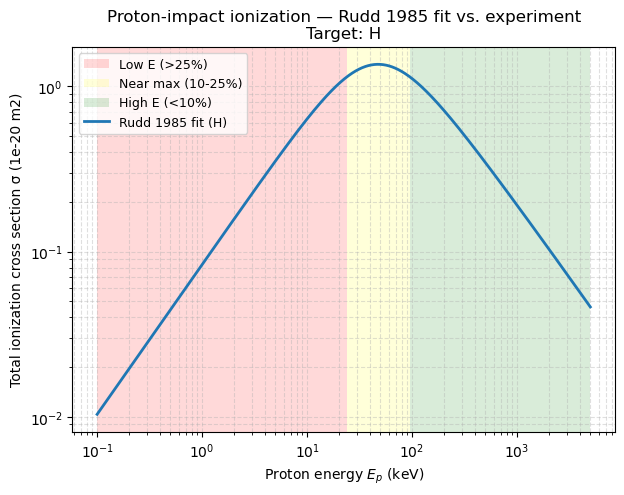

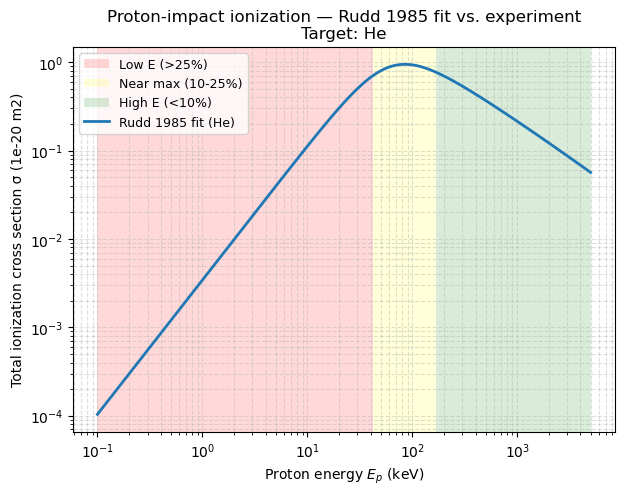

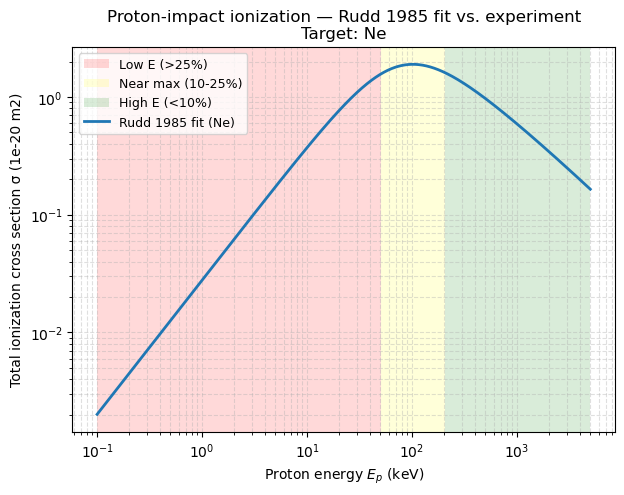

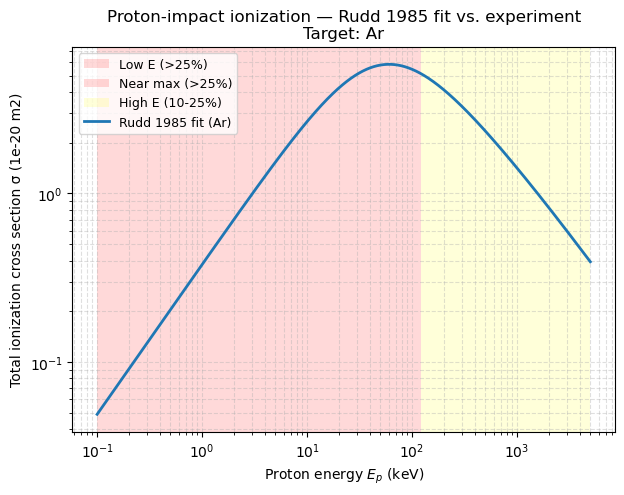

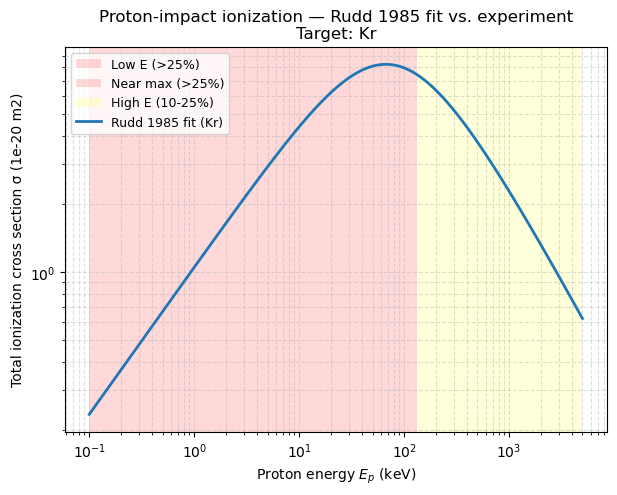

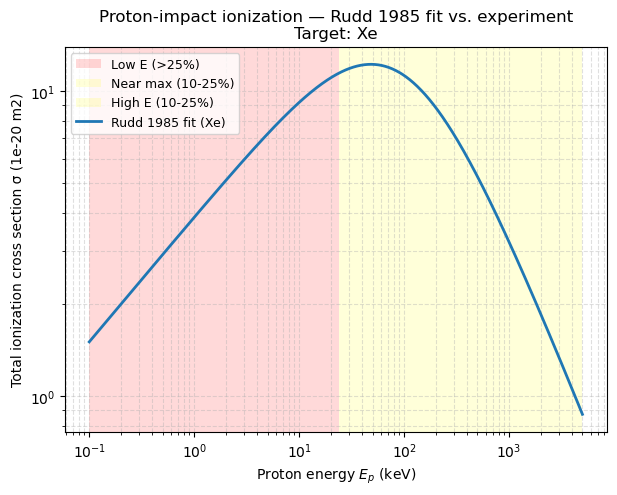

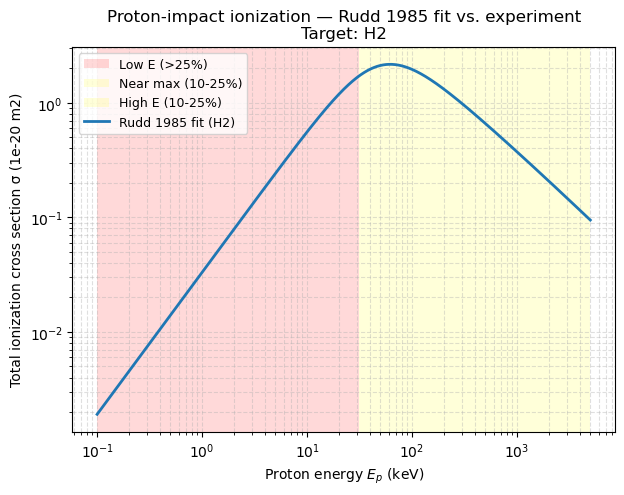

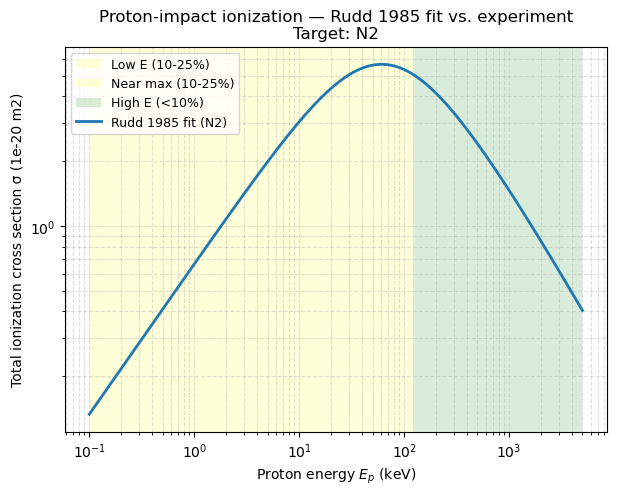

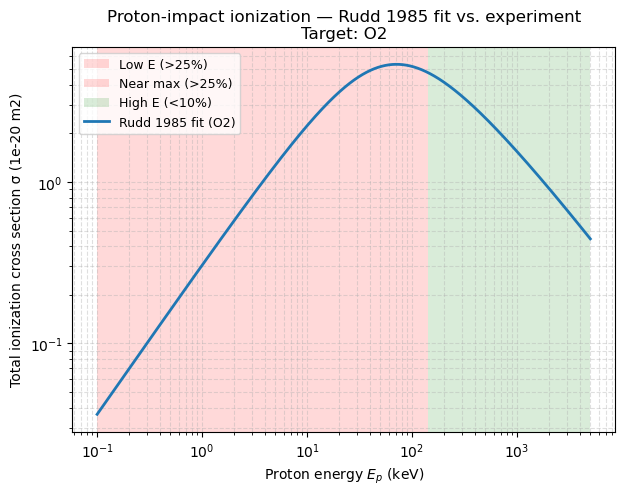

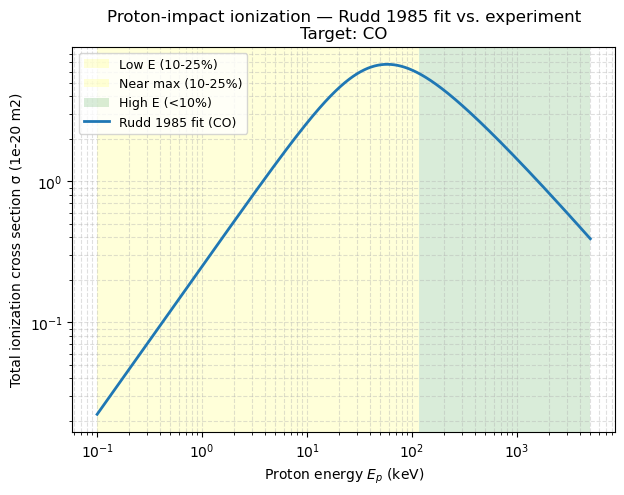

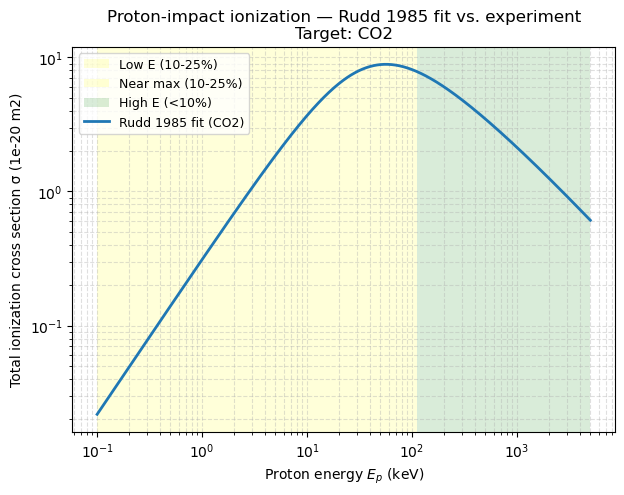

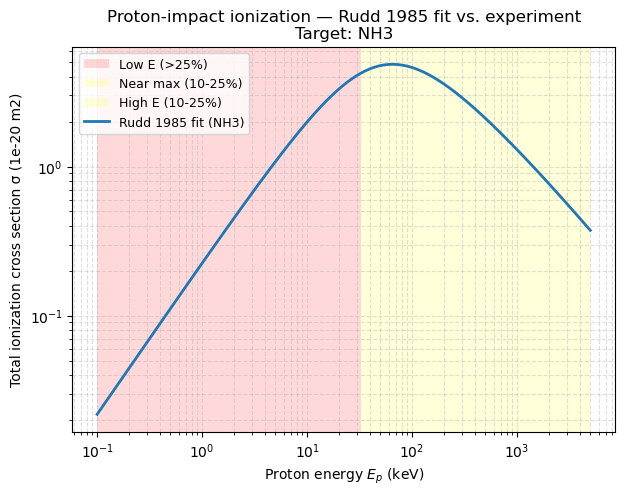

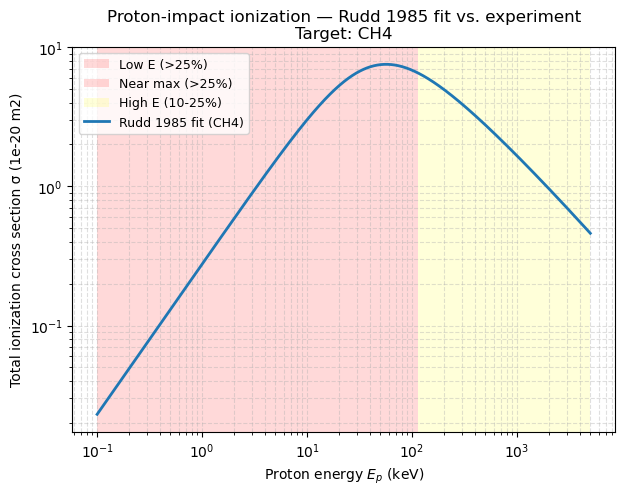

In [2]:
targets = ["H", "He", "Ne", "Ar", "Kr", "Xe", "H2", "N2", "O2", "CO", "CO2", "NH3", "CH4"]
for target in targets:
    plot_rudd_vs_expt(target, Emin_keV=0.1, Emax_keV=5000.0, sigma_units_plot="1e-20 m2")

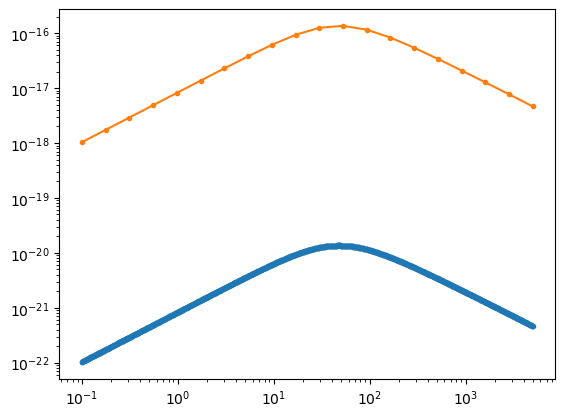

In [8]:
energy, sigma_He = calculate_rudd_sigma(target="H", sigma_units="m2")
plt.plot(energy, sigma_He, '.-')

energy, sigma_He = calculate_rudd_sigma(target="H", sigma_units="cm2", n_points=20)
plt.plot(energy, sigma_He, '.-')

plt.xscale('log')
plt.yscale('log')
plt.show()

---

In [10]:
import pandas as pd

# ---- config ---------------------------------------------------------------
targets = ["H", "He", "Ne", "Ar", "Kr", "Xe"]
Z_map = {"H": 1, "He": 2, "Ne": 10, "Ar": 18, "Kr": 36, "Xe": 54}
Z_ion = 1
theory_id = "Semiempiric_1985Rudd"
Emin_keV = 0.1
Emax_keV = 5000.0
n_points = 500   # same density as your calculate_rudd_sigma
out_csv = "semiempiric_TCS_database_single_ionization_atoms_1985Rudd.csv"
# ---------------------------------------------------------------------------

def _fmt_4sig(x: float) -> str:
    # 4 significant digits total; always scientific notation for consistency
    # precision=3 -> 1 leading digit + 3 after decimal = 4 sig figs
    return np.format_float_scientific(float(x), precision=3, exp_digits=1)

rows = []
for tgt in targets:
    E_keV, sigma_cm2 = calculate_rudd_sigma(target=tgt, sigma_units="cm2", n_points=n_points)
    Zt = Z_map[tgt]

    # Build rows
    rows.append(pd.DataFrame({
        "Z_ion": Z_ion,
        "Z_target": Zt,
        "E_num": E_keV,
        "Theory_ID": theory_id,
        "sigma_num": sigma_cm2,
        "is_exp": 0,
        "Uncertainty[%]": 0
    }))

df = pd.concat(rows, ignore_index=True)

# Sort by numeric energy (and target)
df.sort_values(by=["Z_target", "E_num"], inplace=True)

# Now format to 3 significant digits for CSV output
df["E_proj[keV/u]"] = df["E_num"].map(_fmt_4sig)
df["Cross_section[cm2]"] = df["sigma_num"].map(_fmt_4sig)

# Keep only requested columns, in the requested order
df = df[[
    "Z_ion",
    "Z_target",
    "E_proj[keV/u]",
    "Theory_ID",
    "Cross_section[cm2]",
    "is_exp",
    "Uncertainty[%]"
]]

# Save
df.to_csv(out_csv, index=False)

print(f"Saved {len(df):,} rows to {out_csv}")
print(df.head())

Saved 3,000 rows to semiempiric_TCS_database_single_ionization_atoms_1985Rudd.csv
   Z_ion  Z_target E_proj[keV/u]             Theory_ID Cross_section[cm2]  \
0      1         1         1.e-1  Semiempiric_1985Rudd          1.035e-18   
1      1         1      1.022e-1  Semiempiric_1985Rudd          1.056e-18   
2      1         1      1.044e-1  Semiempiric_1985Rudd          1.077e-18   
3      1         1      1.067e-1  Semiempiric_1985Rudd          1.098e-18   
4      1         1      1.091e-1  Semiempiric_1985Rudd          1.120e-18   

   is_exp  Uncertainty[%]  
0       0               0  
1       0               0  
2       0               0  
3       0               0  
4       0               0  
